In [1]:
import matplotlib.pyplot as plt

import numpy as np

from l5kit.data import ChunkedDataset, LocalDataManager
from l5kit.dataset import EgoDataset, AgentDataset

from l5kit.rasterization import build_rasterizer
from l5kit.configs import load_config_data
from l5kit.visualization import draw_trajectory, TARGET_POINTS_COLOR
from l5kit.geometry import transform_points
from tqdm import tqdm
from collections import Counter
from l5kit.data import PERCEPTION_LABELS
from prettytable import PrettyTable

import os

In [2]:
INPUT_DIR = "C:\\Users\\Nikhil Edward\\Downloads\\Robotics & AI\\project\\content"

The data is assigned to a folder which can be configured using the "L5KIT_DATA_FOLDER" env variable.
The Data folder should contain subfolders for the aerial and semantic maps as well as the scenes. 
yaml file contains useful data, not everything in th eyaml is used here.

In [3]:
# set env variable for data
os.environ["L5KIT_DATA_FOLDER"] = INPUT_DIR
# get config
cfg = load_config_data("./visualisation_config.yaml")
print(cfg)

{'format_version': 4, 'model_params': {'model_architecture': 'resnet50', 'history_num_frames': 0, 'history_step_size': 1, 'history_delta_time': 0.1, 'future_num_frames': 50, 'future_step_size': 1, 'future_delta_time': 0.1}, 'raster_params': {'raster_size': [244, 244], 'pixel_size': [0.5, 0.5], 'ego_center': [0.25, 0.5], 'map_type': 'py_semantic', 'satellite_map_key': 'aerial_map/aerial_map.png', 'semantic_map_key': 'semantic_map/semantic_map.pb', 'dataset_meta_key': 'meta.json', 'filter_agents_threshold': 0.5, 'disable_traffic_light_faces': False}, 'val_data_loader': {'key': 'scenes/sample.zarr', 'batch_size': 12, 'shuffle': False, 'num_workers': 16}}


'.yaml' is in the form of dictionary when loaded.
'ratser_params' has the necessary info for visualiizing 3d scene into image.

In [4]:
print(f'current raster_param:\n')
for k,v in cfg["raster_params"].items():
    print(f"{k}:{v}")

current raster_param:

raster_size:[244, 244]
pixel_size:[0.5, 0.5]
ego_center:[0.25, 0.5]
map_type:py_semantic
satellite_map_key:aerial_map/aerial_map.png
semantic_map_key:semantic_map/semantic_map.pb
dataset_meta_key:meta.json
filter_agents_threshold:0.5
disable_traffic_light_faces:False


config file defined from the above is used to load the data. Building a LocalDataManager object to avoid using the config file's path to read the data. dm: data manager

In [5]:
dm = LocalDataManager()
dataset_path = dm.require(cfg["val_data_loader"]["key"])
zarr_dataset = ChunkedDataset(dataset_path)
zarr_dataset.open()
print(zarr_dataset)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|    100     |   24838    |  1893736   |     316008    |       0.69      |        248.38        |        76.24         |        24.83         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


zarr files support the traditional numpy array operations. To get the scatter plot(centroid distribution) of the AV locations, frames in the zarr file is iterated.

getting centroid to plot trajectory: 100%|██████████████████████████████████████| 24838/24838 [00:40<00:00, 607.87it/s]


(-2500.0, 1600.0)

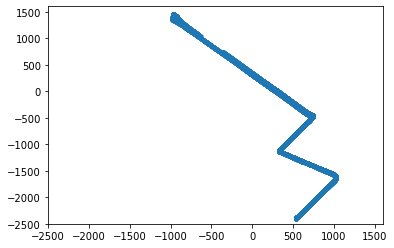

In [6]:
frames = zarr_dataset.frames
coords = np.zeros((len(frames), 2))
for idx_coord, idx_data in enumerate(tqdm(range(len(frames)), desc="getting centroid to plot trajectory")):
    frame = zarr_dataset.frames[idx_data]
    coords[idx_coord] = frame["ego_translation"][:2]


plt.scatter(coords[:, 0], coords[:, 1], marker='.')
axes = plt.gca()
axes.set_xlim([-2500, 1600])
axes.set_ylim([-2500, 1600])

labeled agents' count in the zarr dataset.


In [7]:
agents = zarr_dataset.agents
probabilities = agents["label_probabilities"]
labels_indexes = np.argmax(probabilities, axis=1)
counts = []
for idx_label, label in enumerate(PERCEPTION_LABELS):
    counts.append(np.sum(labels_indexes == idx_label))
    
table = PrettyTable(field_names=["label", "counts"])
for count, label in zip(counts, PERCEPTION_LABELS):
    table.add_row([label, count])
print(table)

+------------------------------------+---------+
|               label                |  counts |
+------------------------------------+---------+
|      PERCEPTION_LABEL_NOT_SET      |    0    |
|      PERCEPTION_LABEL_UNKNOWN      | 1324481 |
|     PERCEPTION_LABEL_DONTCARE      |    0    |
|        PERCEPTION_LABEL_CAR        |  519385 |
|        PERCEPTION_LABEL_VAN        |    0    |
|       PERCEPTION_LABEL_TRAM        |    0    |
|        PERCEPTION_LABEL_BUS        |    0    |
|       PERCEPTION_LABEL_TRUCK       |    0    |
| PERCEPTION_LABEL_EMERGENCY_VEHICLE |    0    |
|   PERCEPTION_LABEL_OTHER_VEHICLE   |    0    |
|      PERCEPTION_LABEL_BICYCLE      |    0    |
|    PERCEPTION_LABEL_MOTORCYCLE     |    0    |
|      PERCEPTION_LABEL_CYCLIST      |   6688  |
|   PERCEPTION_LABEL_MOTORCYCLIST    |    0    |
|    PERCEPTION_LABEL_PEDESTRIAN     |  43182  |
|      PERCEPTION_LABEL_ANIMAL       |    0    |
|     AVRESEARCH_LABEL_DONTCARE      |    0    |
+-------------------

We will use two classes from the dataset package Both of them are iterated and returns multi-channel images from the rasterizer along with future trajectories offsets.

    EgoDataset: this dataset iterates over the AV annotations
    AgentDataset: this dataset iterates over other agents annotations
dm : datamanger, cfg: configuration file

EgoDatset() results: trajectories offsets


In [14]:
rast = build_rasterizer(cfg, dm)
dataset = EgoDataset(cfg, zarr_dataset, rast)

Rasterized Images from the datset above further rasterizing and transforming position pixels,the Birds Eye view of the trajectory (agents'/frames')image in the scene.

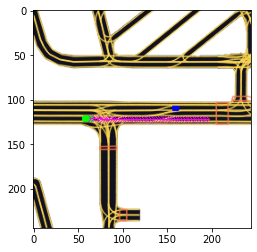

In [9]:
data = dataset[50]

im = data["image"].transpose(1, 2, 0)
im = dataset.rasterizer.to_rgb(im)
target_positions_pixels = transform_points(data["target_positions"], data["raster_from_agent"])
draw_trajectory(im, target_positions_pixels, TARGET_POINTS_COLOR, yaws=data["target_yaws"])

plt.imshow(im[::-1])
plt.show()

with respective raster_parms and map_type, satelliteview of the image is obtained from the configuration file.
further rasterizing and transforming position pixels,the satellite view of the trajectory (agents'/frames')image in the scene. 

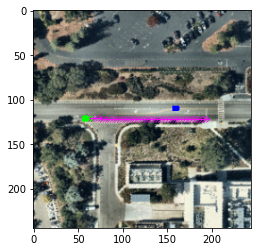

In [10]:


cfg["raster_params"]["map_type"] = "py_satellite"
rast = build_rasterizer(cfg, dm)
dataset = EgoDataset(cfg, zarr_dataset, rast)
data = dataset[50]

im = data["image"].transpose(1, 2, 0)
im = dataset.rasterizer.to_rgb(im)
target_positions_pixels = transform_points(data["target_positions"], data["raster_from_agent"])
draw_trajectory(im, target_positions_pixels, TARGET_POINTS_COLOR, yaws=data["target_yaws"])

plt.imshow(im[::-1])
plt.show()



With AgentDataset information, Agents are visualized in the rasterzed satellite view

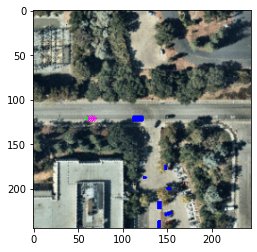

In [11]:
dataset = AgentDataset(cfg, zarr_dataset, rast)
data = dataset[0]

im = data["image"].transpose(1, 2, 0)
im = dataset.rasterizer.to_rgb(im)
target_positions_pixels = transform_points(data["target_positions"], data["raster_from_agent"])
draw_trajectory(im, target_positions_pixels, TARGET_POINTS_COLOR, yaws=data["target_yaws"])

plt.imshow(im[::-1])
plt.show()

Surrounding agents,Frame(AV), trajectories of both Agent, Frame are visualized on the rasterized image in the scene 

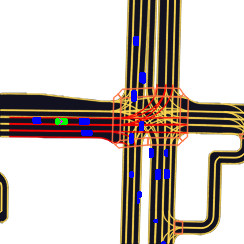

In [18]:
from IPython.display import display, clear_output
import PIL
 
cfg["raster_params"]["map_type"] = "py_semantic"
rast = build_rasterizer(cfg, dm)
dataset = EgoDataset(cfg, zarr_dataset, rast)
scene_idx = 1
indexes = dataset.get_scene_indices(scene_idx)
images = []

for idx in indexes:
    
    data = dataset[idx]
    im = data["image"].transpose(1, 2, 0)
    im = dataset.rasterizer.to_rgb(im)
    target_positions_pixels = transform_points(data["target_positions"], data["raster_from_agent"])
    center_in_pixels = np.asarray(cfg["raster_params"]["ego_center"]) * cfg["raster_params"]["raster_size"]
    draw_trajectory(im, target_positions_pixels, TARGET_POINTS_COLOR, yaws=data["target_yaws"])
    clear_output(wait=True)
    display(PIL.Image.fromarray(im[::-1]))